# PWV effects on SN Magnitude

This notebook demonstrates the effects of PWV absorption on the apparent magnitude of SNe. It is constructed to present a linear exploration of the results and includes a mix of validation plots and scientific results.


In [1]:
import sys
sys.path.insert(0, '../')

import numpy as np
import sncosmo
from matplotlib import pyplot as plt
from sn_analysis import modeling, sn_magnitudes, reference, plotting
from utils import register_decam_filters

register_decam_filters(force=True)


In [2]:
source = 'salt2-extended'
pwv_vals = np.arange(0, 10)
z_vals = np.arange(.01, 1.1, .05)
bands = 'decam_r', 'decam_i', 'decam_z', 'decam_y'


## Template Spectrum

The effect of PWV absorption is fundementally dpendent on the interplay between the SED of the effected object and the PWV transmission function. For this work we consider an extend version of the Salt2 spectral template. We visualize the template as a reference.


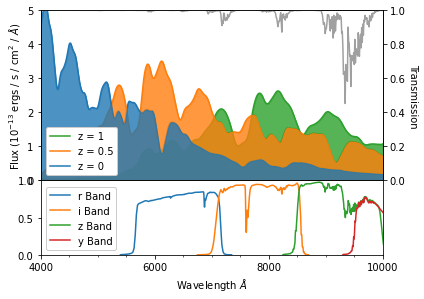

In [3]:
_ = plotting.plot_salt2_extended_template(np.arange(4000, 10000), [0, .5, 1], pwv=4)


## Apparent magnitude

We start by considering the direct impact of PWV absorbtion on simulated SN Ia magnitudes. Apparent magnitudes are simulated for multiple bands / redshifts / PWV concentrations. 


In [4]:
tabulated_mag = sn_magnitudes.tabulate_mag(source, pwv_vals, z_vals, bands)


Tabulating Mag: 100%|██████████| 880/880 [01:44<00:00,  8.46it/s]


As the spectral template is redshifted, the brighter portion of the spectra begins to enter the redder bands. We expect this to cause a temporary decrease in the apparent magnitude until the redshift becomes large enough that growing distance results in a monotonically increasing magnitude (This effect becomes more obvious when looking at the spectra template above).

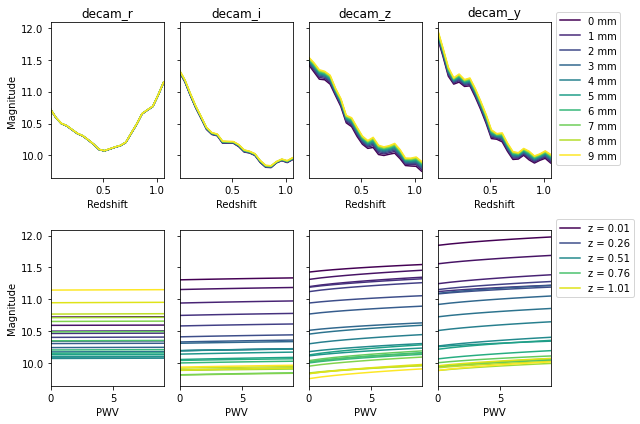

In [5]:
_ = plotting.plot_magnitude(tabulated_mag, pwv_vals, z_vals)

To better understand the impact of PWV, we estimate the change in apparent magnitude due to PWV. Although we could measure this change relative to PWV=0, a more physically motivated approach is to use a fiducial atmosphere with a non-zero PWV component:

$$\Delta m = m(\text{PWV}, z) - m(\text{PWV}_f, z)$$

Note that the resulting value of $\Delta m$ is equivilent to the apparent magnitude normalized to the flux through the fiducial atmosphere.

$$\Delta m = m(\text{PWV}, z) - m(\text{PWV}_f, z) = -2.5 log\left(\frac{f(\text{PWV}, z)}{f(\text{PWV}_f, z)}\right)$$

We also determine the slope in the apparent magnitude as an estimate for how sensitive our simulated observations are to PWV fluxtuations:

$$\frac{\Delta m}{\Delta \text{PWV}}(z) = \frac{m(\text{PWV}_2, z) - m(\text{PWV}_1, z)}{\text{PWV}_2 - \text{PWV}_1}$$

where PWV$_1$ and PWV$_2$ are arbitrarily chosen PWV values that are equidistant to PWV$_f$. We take note of these PWV reference values in the following cell:


In [6]:
reference_pwv_config = reference.get_config_pwv_vals()
print(reference_pwv_config)


{'reference_pwv': 4.0, 'slope_start': 2.0, 'slope_end': 6.0}


Next we tabulate values for $\Delta m$ and $\frac{\Delta m}{\Delta \text{PWV}}(z)$.

In [7]:
fiducial_mag = sn_magnitudes.tabulate_fiducial_mag(
        source, z_vals, bands, reference_pwv_config)

tabulated_delta_mag, tabulated_slope = sn_magnitudes.calc_delta_mag(
    tabulated_mag, fiducial_mag, reference_pwv_config)


Tabulating Mag: 100%|██████████| 264/264 [00:31<00:00,  8.42it/s]


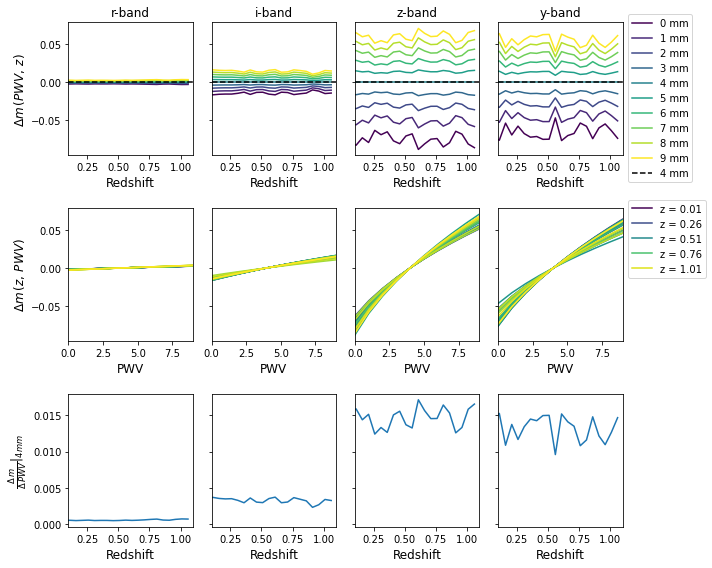

In [8]:
_ = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    tabulated_delta_mag, 
    tabulated_slope, 
    bands)


In practice flux values are calibrated relative to a reference star. To understand how PWV effects SNe fluxes under these conditions, we normalize the SNe and Reference star flux to their respective fluxes through the fiducial atmosphere and take the difference (Normalized SNe - normalized reference star).

In [9]:
def calibrate_to_reference(delta_mag, slope, pwv_vals):
    
    assert delta_mag.keys() == slope.keys()
    reference_pwv_config = reference.get_config_pwv_vals()
    
    delta_mag_ref = {}
    slope_ref = {}
    for band in delta_mag:
        
        delta_mag_ref[band] = reference.subtract_ref_star(
            band, delta_mag[band], pwv_vals)
        
        slope_ref[band] = reference.subtract_ref_star_slope(
            band, slope[band], reference_pwv_config)
        
    return delta_mag_ref, slope_ref
        

In [10]:
# The y band values are not available for the reference star
# we drop them here

_tabulated_delta_mag = tabulated_delta_mag.copy()
_tabulated_delta_mag.pop('decam_y')

_tabulated_slope = tabulated_slope.copy()
_tabulated_slope.pop('decam_y')

tabulated_delta_mag_ref = reference.subtract_ref_star(_tabulated_delta_mag, pwv_vals)
tabulated_slope_ref = reference.subtract_ref_star_slope(_tabulated_slope, reference_pwv_config)


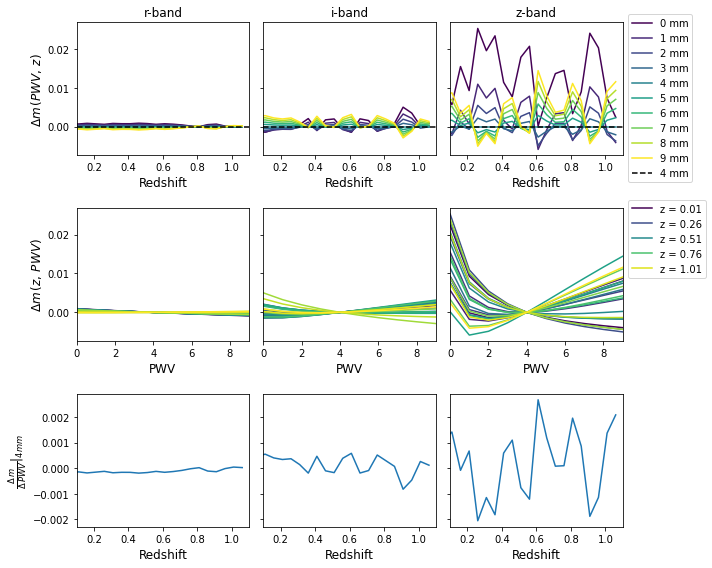

In [11]:
_ = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    tabulated_delta_mag_ref, 
    tabulated_slope_ref, 
    bands[:-1])


## 5. $\Delta m$ With Fitting

We determine the change in apparent magnitude by simulating light-curves with PWV effects and then fitting a model without a PWV component.

In [12]:
# Realize simulations of light-curves
observations = modeling.create_observations_table()
light_curves = modeling.iter_lcs(observations, source, pwv_vals, z_vals)

# Fit light curves
vparams = ['x0', 'x1', 'c']
fitted_mag, fitted_params = sn_magnitudes.fit_mag(
        source, light_curves, vparams, pwv_vals, z_vals, bands)

# Get fiducial mag (uncalibrated)
fitted_fiducial_mag, fitted_fiducial_params = sn_magnitudes.fit_fiducial_mag(
        source, observations, vparams, z_vals, bands, reference_pwv_config)


Light-Curves: 100%|██████████| 66/66 [00:38<00:00,  1.70it/s]


Text(0.5, 1.05, 'Fitted Magnitude')

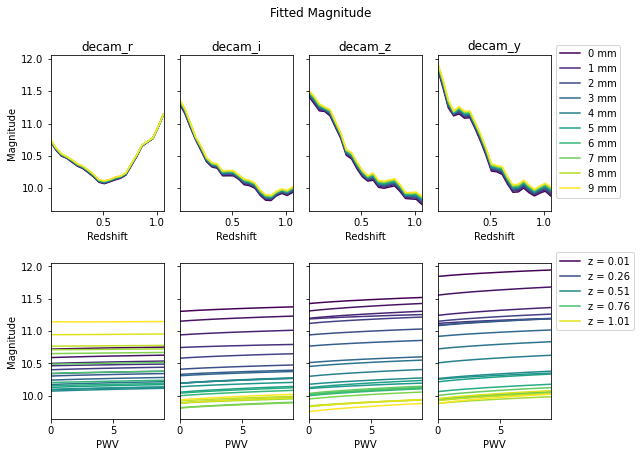

In [13]:
fig, axes = plotting.plot_magnitude(fitted_mag, pwv_vals, z_vals)
fig.suptitle('Fitted Magnitude', y=1.05)


We pause to check that the fitted parameters follow trends that make sense.

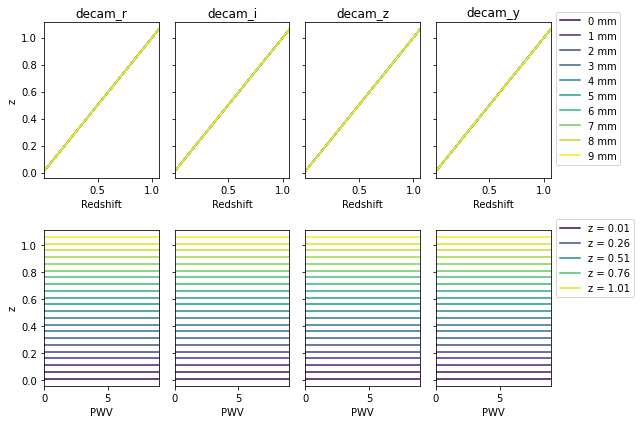

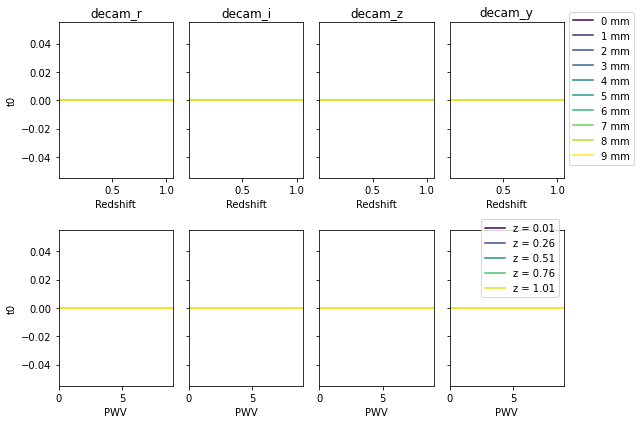

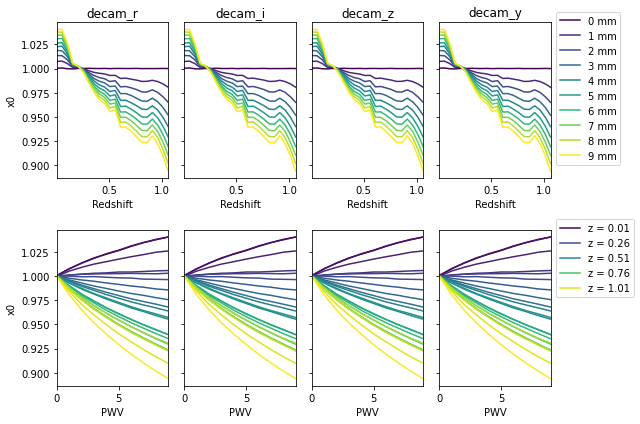

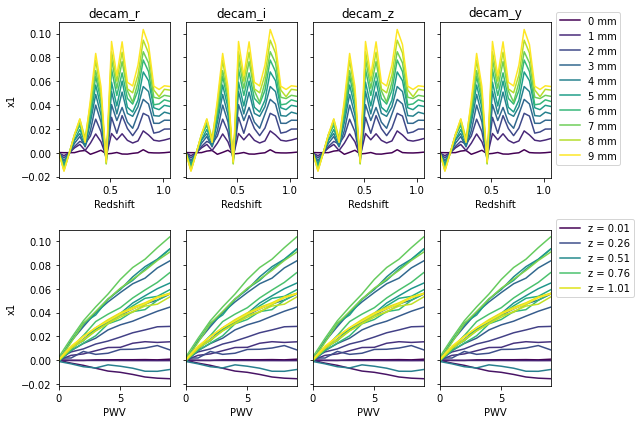

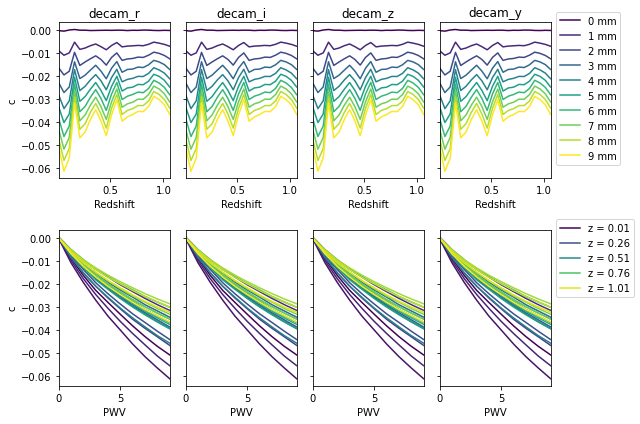

In [14]:
model = sncosmo.Model('salt2-extended')
for i, param in enumerate(model.param_names):
    plt_data = {b: v[..., i] for b, v in fitted_params.items()}
    fig, axes = plotting.plot_magnitude(plt_data, pwv_vals, z_vals)
    axes[0][0].set_ylabel(param)
    axes[1][0].set_ylabel(param)


We also visualize the resulting calibration term.

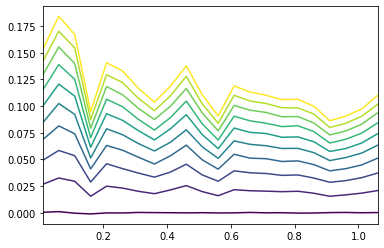

In [31]:
c_i = model.param_names.index('c')
x1_i = model.param_names.index('x1')

param_arr = fitted_params[bands[0]]
correction_factor = sn_magnitudes.α * param_arr[..., i] - sn_magnitudes.β * param_arr[..., i]

fig, axis = plt.subplots(1, 1)
plotting.multi_line_plot(z_vals, correction_factor, pwv_vals, axis)


Like before we look at the impace of PWV on the fitted magnitude, the calibrated magnitude, and the calibrated magnitude with respect to a reference star.

In [15]:
fitted_delta_mag, fitted_slope = sn_magnitudes.calc_delta_mag(
    fitted_mag, fitted_fiducial_mag, reference_pwv_config)


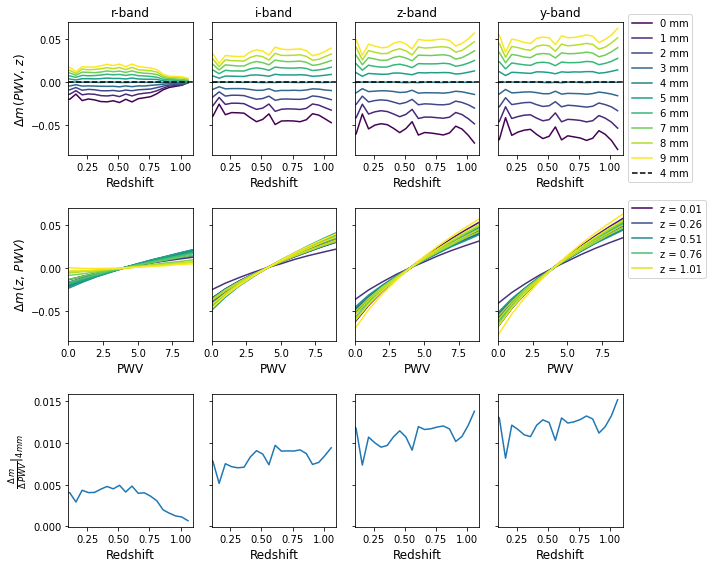

In [16]:
fig, axes = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    fitted_delta_mag, 
    fitted_slope, 
    bands)


Next we add in the alpha and beta parameters from the fit.

In [17]:
# Determine calibrated magnitude from fits
calibrated_mag = {}
calibrated_fiducial_mag = {}
for band in bands:
    calibrated_mag[band] = sn_magnitudes.calibrate_mag(
        source, fitted_mag[band], fitted_params[band])

    # Get fiducial mag (calibrated)
    calibrated_fiducial_mag[band] = sn_magnitudes.calibrate_mag(
        source, fitted_fiducial_mag[band], fitted_fiducial_params[band])

calibrated_delta_mag, calibrated_slope = sn_magnitudes.calc_delta_mag(
        calibrated_mag, calibrated_fiducial_mag, reference_pwv_config)


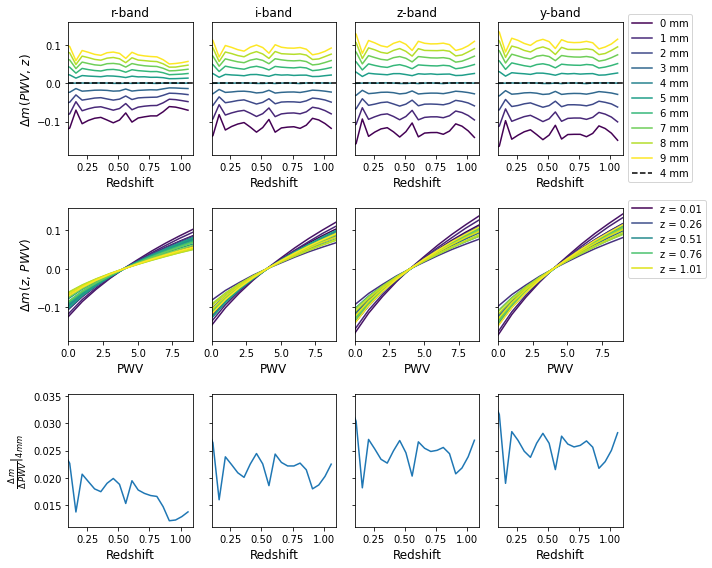

In [18]:
_ = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    calibrated_delta_mag, 
    calibrated_slope, 
    bands)


In [33]:
# The y band values are not available for the reference star
# we drop them here

_fitted_delta_mag = fitted_delta_mag.copy()
_fitted_delta_mag.pop('decam_y')

_fitted_slope = fitted_slope.copy()
_fitted_slope.pop('decam_y')

fitted_delta_mag_ref = reference.subtract_ref_star(_fitted_delta_mag, pwv_vals)
fitted_slope_ref = reference.subtract_ref_star_slope(_fitted_slope, reference_pwv_config)


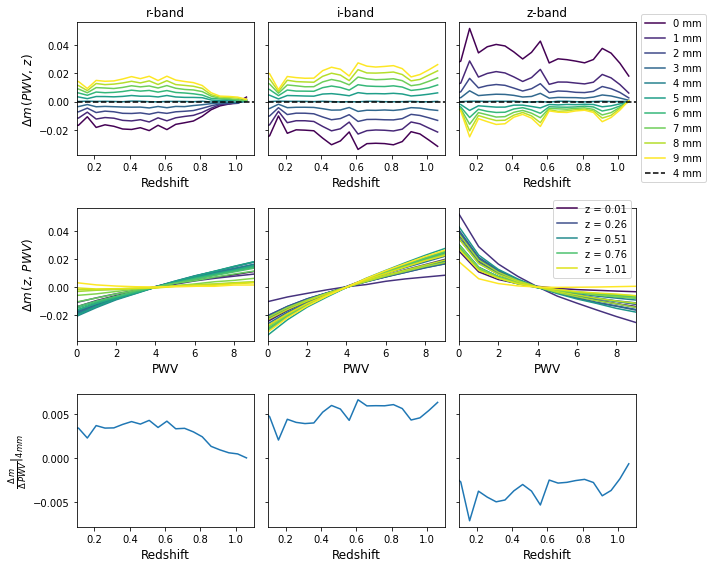

In [34]:
_ = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    fitted_delta_mag_ref, 
    fitted_slope_ref, 
    bands)
